In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Data input and processing

In [2]:
def standard_error(series):
    return series.std() / np.sqrt(series.count())

def process_data(new_file_path, previous_df=None):
    """
    Processes the experiment data from a new CSV file. If a previous DataFrame is provided,
    appends the new data to it; otherwise, creates a new DataFrame.

    Parameters:
    previous_df (pandas.DataFrame, optional): The existing DataFrame to append to. Defaults to None.
    new_file_path (str): The file path to the new CSV file containing the experiment data.

    Returns:
    pandas.DataFrame: A DataFrame with the combined data.
    """
    # Load the data from the new CSV file
    new_data = pd.read_csv(new_file_path)

    # Add a new column for method_name based on the value of method
    new_data['method_name'] = new_data.apply(lambda x: x['prune_method'] if x['method'] == 'prune' else x['quant_method'] if x['method'] == 'quant' else None, axis=1)
    new_data['method_name'] = new_data['method_name'].replace({'autoawq': 'AWQ', 'autogptq': 'GPTQ', 'sparsegpt': 'SparseGPT', 'wanda': 'Wanda'})

    # Check if 'PPL edits' column exists
    if 'PPL edits' in new_data.columns:
        aggregation_columns = ['Rewrite accuracy', 'PPL', 'Generalization', 'Latency', 'Locality', 'PPL edits', 'PPl edits unmasked']
    else:
        aggregation_columns = ['Rewrite accuracy', 'PPL', 'Generalization', 'Latency', 'Locality']
        # new_data['PPL edits'] = np.nan  # Create an empty 'PPL edits' column


    # Group by 'Tags' and calculate mean and standard error for the selected columns
    grouped_new_data = new_data.groupby('Tags')[aggregation_columns].agg(['mean', standard_error])

    # Flatten multi-level columns and rename them
    grouped_new_data.columns = ['_'.join(col).strip() for col in grouped_new_data.columns.values]

    # Merge the grouped new data with the extracted information
    final_new_df = pd.merge(grouped_new_data.reset_index(), new_data[['Tags', 'alg_name', 'model', 'edit', 'compress', 'sparsity_ratio', 'method_name', 'Average bits']], 
                            on='Tags', how='left').drop_duplicates()

    # Reordering columns
    final_cols = ['alg_name', 'model', 'edit', 'compress', 'sparsity_ratio', 'method_name'] + \
                 [col for col in final_new_df.columns if col not in ['alg_name', 'model', 'edit', 'compress', 'sparsity_ratio', 'Tags', 'method_name']]
    final_new_df = final_new_df[final_cols]

    # If a previous DataFrame is provided, append the new data; otherwise, use the new data as the DataFrame
    if previous_df is not None:
        combined_df = pd.concat([previous_df, final_new_df], ignore_index=True)
    else:
        combined_df = final_new_df

    return combined_df

In [3]:
## Counterfact

# No edits
unedited_counterfact = process_data('data/counterfact/none.csv')
unedited_counterfact = process_data('data/counterfact/noedit_compress.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/noedit_compress_extra.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W4_GPTQ.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W8_GPTQ.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W4_AWQ.csv', unedited_counterfact)

# With MEMIT
edited_counterfact = process_data('data/counterfact/memit.csv')
edited_counterfact = process_data('data/counterfact/edit_compress.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/edit_compress_extra.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W4_Edits_GPTQ.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W8_Edits_GPTQ.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W4_Edits_AWQ.csv', edited_counterfact)

# Compress First
compfirst_counterfact = process_data('data/counterfact/memit.csv')
compfirst_counterfact = process_data('data/counterfact/compress_first.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W3_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W4_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W8_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)

models = ['Pythia2.8B', 'Pythia410M', 'Pythia1b']
for model in models:
    model_path = f'data/counterfact/{model}/'

    # No edits
    unedited_counterfact = process_data(model_path + 'W8_GPTQ.csv', unedited_counterfact)
    unedited_counterfact = process_data(model_path + 'W4_GPTQ.csv', unedited_counterfact)
    unedited_counterfact = process_data(model_path + 'W4_AWQ.csv', unedited_counterfact)
    unedited_counterfact = process_data(model_path + 'W3_GPTQ.csv', unedited_counterfact)

    # With MEMIT
    edited_counterfact = process_data(model_path + 'W8_Edits_GPTQ.csv', edited_counterfact)
    edited_counterfact = process_data(model_path + 'W4_Edits_GPTQ.csv', edited_counterfact)
    edited_counterfact = process_data(model_path + 'W4_Edits_AWQ.csv', edited_counterfact)
    edited_counterfact = process_data(model_path + 'W3_Edits_GPTQ.csv', edited_counterfact)

    # Compress First
    compfirst_counterfact = process_data(model_path + 'W8_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
    compfirst_counterfact = process_data(model_path + 'W4_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
    compfirst_counterfact = process_data(model_path + 'W3_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)

## ZSRE

# No edits
unedited_zsre = process_data('data/zsre/none.csv')
unedited_zsre = process_data('data/zsre/noedit_compress.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/noedit_compress_extra.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/ZSRE_W4_GPTQ.csv', unedited_zsre)  # Updated file name
unedited_zsre = process_data('data/zsre/ZSRE_W8_GPTQ.csv', unedited_zsre)  # Updated file name
unedited_zsre = process_data('data/zsre/ZSRE_W4_AWQ.csv', unedited_zsre)  # Updated file name

# With MEMIT
edited_zsre = process_data('data/zsre/memit.csv')
edited_zsre = process_data('data/zsre/edit_compress.csv', edited_zsre)
edited_zsre = process_data('data/zsre/edit_compress_extra.csv', edited_zsre)
edited_zsre = process_data('data/zsre/ZSRE_W4_Edits_GPTQ.csv', edited_zsre)  # Updated file name
edited_zsre = process_data('data/zsre/ZSRE_W8_Edits_GPTQ.csv', edited_zsre)  # Updated file name
edited_zsre = process_data('data/zsre/ZSRE_W4_Edits_AWQ.csv', edited_zsre)  # Updated file name

# Compress first
compfirst_zsre = process_data('data/zsre/compress_first.csv')
compfirst_zsre = process_data('data/zsre/memit_only.csv', compfirst_zsre)
compfirst_zsre = process_data('data/zsre/ZSRE_W8_GPTQ_Edits_GPTQ.csv', compfirst_zsre)
compfirst_zsre = process_data('data/zsre/ZSRE_W4_GPTQ_Edits_GPTQ.csv', compfirst_zsre)

## MQ

# No edits
unedited_mq = process_data('data/MQ/noedit_compress.csv')
unedited_mq = process_data('data/MQ/noedit_compress_extra.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W4_GPTQ.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W8_GPTQ.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W4_AWQ.csv', unedited_mq)

# With MEMIT
edited_mq = process_data('data/MQ/edit_compress.csv')
edited_mq = process_data('data/MQ/edit_compress_extra.csv', edited_mq)
edited_mq = process_data('data/MQ/W4_Edits_GPTQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W8_Edits_GPTQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W4_Edits_AWQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W3_Edits_GPTQ.csv', edited_mq)

# Compress first
compfirst_mq = process_data('data/MQ/compress_first.csv')
compfirst_mq = process_data('data/MQ/memit_only.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W8_GPTQ_Edits_GPTQ.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W4_GPTQ_Edits_GPTQ.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W3_GPTQ_Edits_GPTQ.csv', compfirst_mq)



In [9]:
print(edited_counterfact.columns)
print(edited_counterfact[edited_counterfact['model'] == 'EleutherAI/pythia-1b'])
print(edited_counterfact['model'].unique())


Index(['alg_name', 'model', 'edit', 'compress', 'sparsity_ratio',
       'method_name', 'Rewrite accuracy_mean',
       'Rewrite accuracy_standard_error', 'PPL_mean', 'PPL_standard_error',
       'Generalization_mean', 'Generalization_standard_error', 'Latency_mean',
       'Latency_standard_error', 'Locality_mean', 'Locality_standard_error',
       'PPL edits_mean', 'PPL edits_standard_error', 'PPl edits unmasked_mean',
       'PPl edits unmasked_standard_error', 'Average bits'],
      dtype='object')
   alg_name                 model  edit  compress  sparsity_ratio method_name  \
91    MEMIT  EleutherAI/pythia-1b  True      True            0.25        GPTQ   
92    MEMIT  EleutherAI/pythia-1b  True      True            0.25        GPTQ   
93    MEMIT  EleutherAI/pythia-1b  True      True            0.25         AWQ   
94    MEMIT  EleutherAI/pythia-1b  True      True            0.25        GPTQ   

    Rewrite accuracy_mean  Rewrite accuracy_standard_error   PPL_mean  \
91           

### Metrics vs avg bits

/home/sux7mp/.conda/envs/llm_310/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/sux7mp/.conda/envs/llm_310/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/sux7mp/.conda/envs/llm_310/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/sux7mp/.conda/envs/llm_310/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/sux7mp/.conda/envs/llm_310/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axi

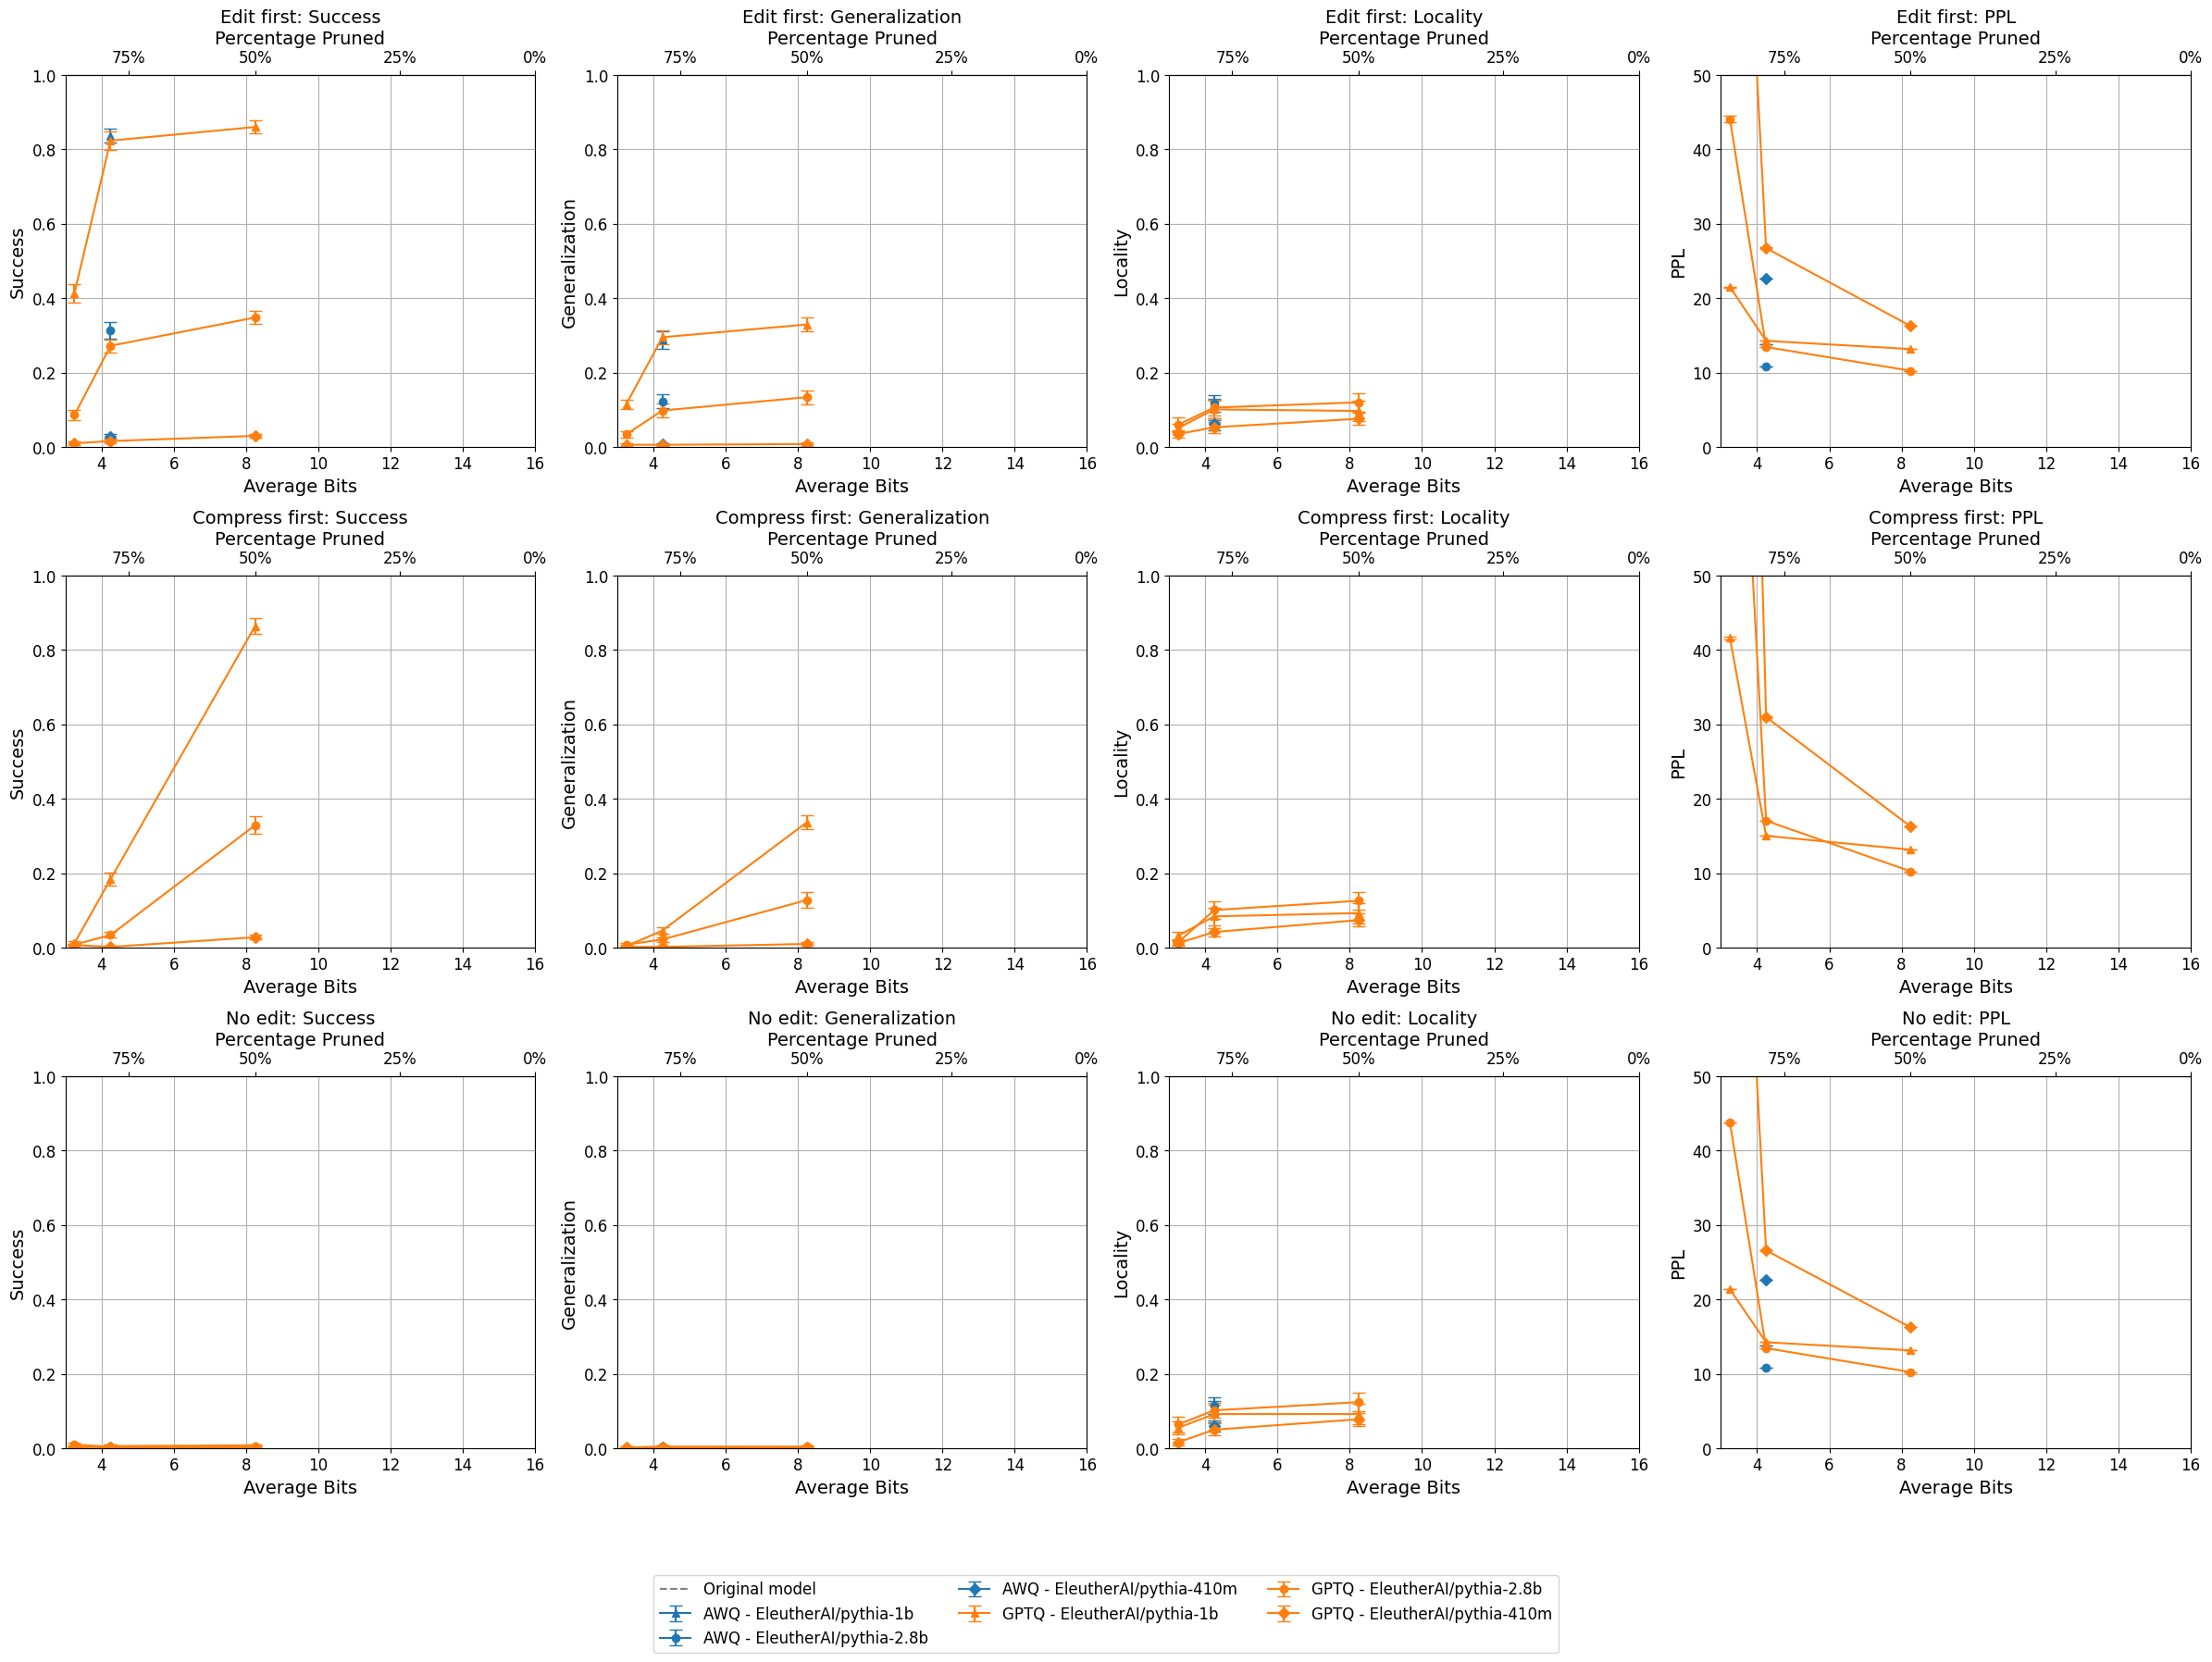

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(dataframes, titles, metrics, included_models):
    num_dfs = len(dataframes)
    fig, axs = plt.subplots(num_dfs, len(metrics), figsize=(24, 6 * num_dfs))
    
    # Define font sizes
    title_fontsize = 14
    label_fontsize = 14
    legend_fontsize = 12
    tick_fontsize = 12

    # Flatten the list of unique method names and models across all dataframes
    all_methods = set(method for df in dataframes for method in df['method_name'].unique())
    all_models = set(model for df in dataframes for model in df['model'].unique())

    # Define color and marker mappings
    method_colors = {method: f'C{i}' for i, method in enumerate(all_methods)}
    model_markers = {model: marker for model, marker in zip(all_models, ['o-', 's-', '^-', 'D-', 'v-', '<', '>', 'p'])}

    for df_index, df in enumerate(dataframes):
        # Filter the DataFrame to include only specified models
        df = df[df['model'].isin(included_models)]

        baseline_values = {metric: df[df['sparsity_ratio'] == 0][metric].mean() for metric in metrics}
        
        for i, metric in enumerate(metrics):
            ax = axs[df_index, i] if num_dfs > 1 else axs[i]
            ylabel = 'Success' if 'Rewrite accuracy' in metric else metric.split('_')[0]
            if titles[df_index] == 'MQuAKE':
                ylabel = 'One-hop' if 'Locality' in metric else metric.split('_')[0]
            ax.axhline(y=baseline_values[metric], color='gray', linestyle='--', label='Original model')

            grouped_df = df.groupby(['method_name', 'model'])
            for (method, model), group in grouped_df:
                label = f"{method} - {model}"
                color = method_colors[method]
                marker = model_markers[model]

                new_data = pd.DataFrame({'Average bits': [16], metric: [baseline_values[metric]]})
                extended_method_data = pd.concat([group, new_data], ignore_index=True)
                extended_method_data_sorted = extended_method_data.sort_values(by='Average bits', ascending=False)

                ax.errorbar(extended_method_data_sorted['Average bits'], extended_method_data_sorted[metric], 
                            yerr=extended_method_data_sorted[metric.replace('mean', 'standard_error')].fillna(0), 
                            fmt=marker, color=color, label=label, capsize=5)

            ax.set_xlabel('Average Bits', fontsize=label_fontsize)
            ax.set_ylabel(ylabel, fontsize=label_fontsize)
            ax.set_title(f'{titles[df_index]}: {ylabel}', fontsize=title_fontsize)
            ax.grid(True)
            ax.set_xlim(3, 16)
            ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

            if i < 3:
                ax.set_ylim(0, 1)
            else:
                ax.set_ylim(0, 50)

            secax = ax.secondary_xaxis('top')
            secax.set_xlabel('Percentage Pruned', fontsize=label_fontsize)
            secax.set_xticks([1, 4.75, 8.25, 12.25, 16])
            secax.set_xticklabels(['100%', '75%', '50%', '25%', '0%'], fontsize=tick_fontsize)

    # Place the legend at the bottom of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.0), fontsize=legend_fontsize)

    plt.tight_layout(rect=[0, 0.09, 1, 1])  # Adjust the rectangle to make space for the legend
    plt.show()

# Example usage
# ['meta-llama/Llama-2-7b-chat-hf', 'EleutherAI/pythia-2.8b', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1b']
included_models = ['EleutherAI/pythia-2.8b', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1b']  # Replace with the models you want to include
dfs = [edited_counterfact, compfirst_counterfact, unedited_counterfact]
metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']
titles = ['Edit first', 'Compress first', 'No edit']
plot_metrics(dfs, titles, metrics, included_models)


### Metrics vs NLL

True
Success
False
Generalization
False
Locality
False
PPL


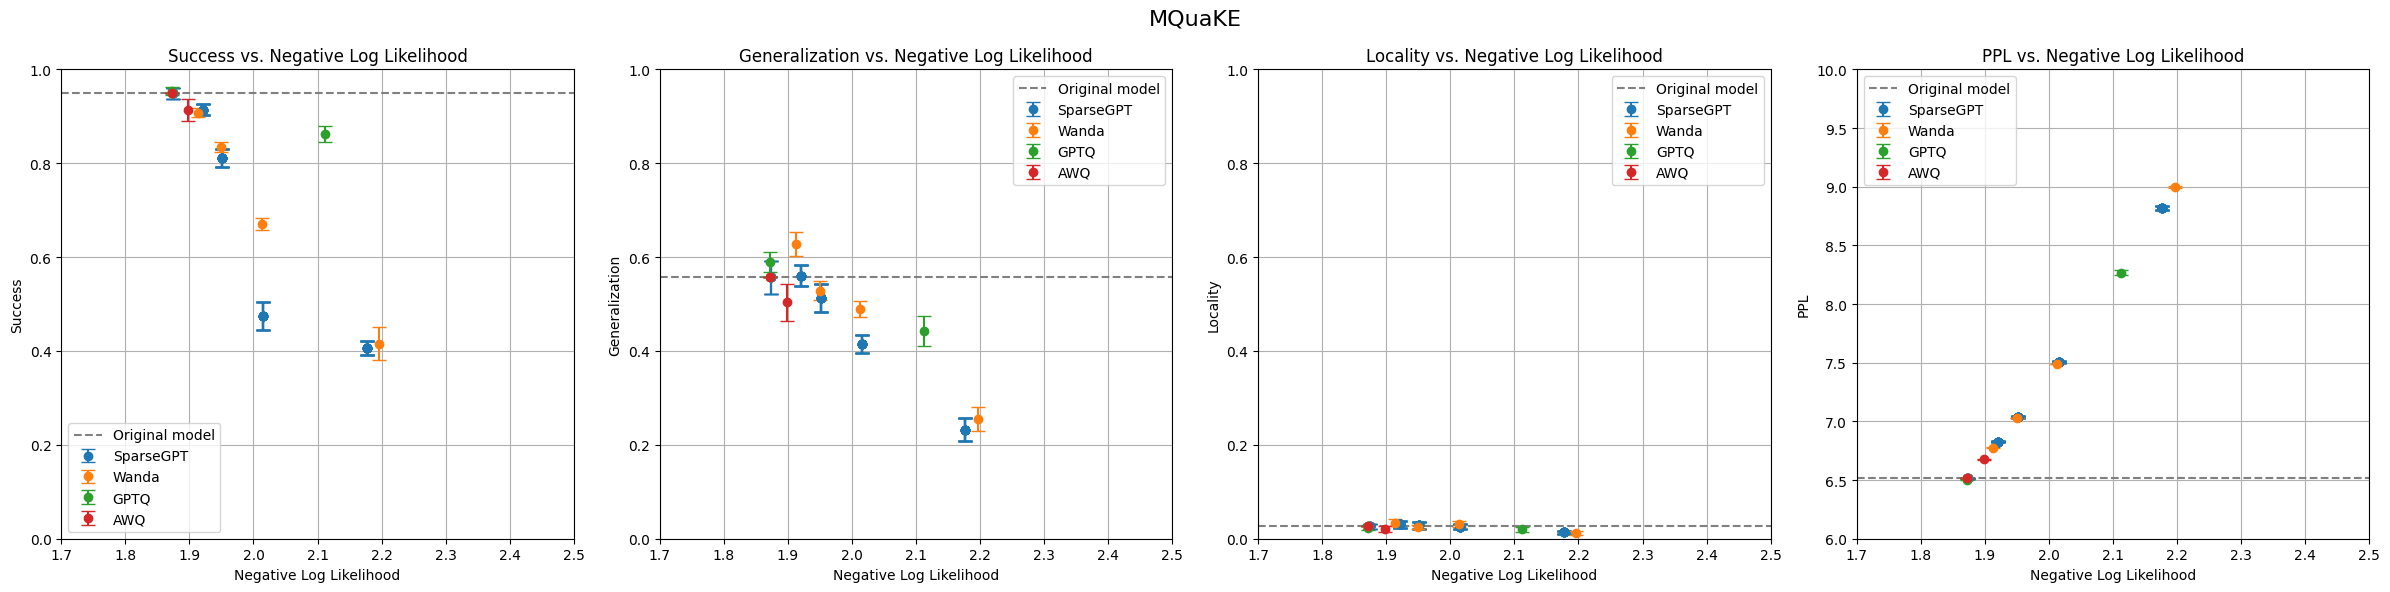

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your DataFrame here

df = edited_mq  # Use your DataFrame

metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Extract baseline values for each metric
baseline_values = {metric: df[df['sparsity_ratio'] == 0][metric].mean() for metric in metrics}

# Compute NLL from PPL
df['NLL'] = np.log(df['PPL_mean'])

for i, metric in enumerate(metrics):
    # Change the label 'Rewrite accuracy' to 'Success'
    # print(metric)
    print( 'Rewrite' in metric)
    ylabel = 'Success' if 'Rewrite' in metric else metric.split('_')[0]
    # print(ylabel)
    ylabel = 'One-hop' if 'Locality' in metric else metric.split('_')[0]

    # Plot baseline as a horizontal dotted line
    axs[i].axhline(y=baseline_values[metric], color='gray', linestyle='--', label='Original model')

    # Plot each method in the dataset, including a baseline point at the start
    for method in df['method_name'].unique():
        method_data = df[df['method_name'] == method]
        # Prepend the baseline data point
        baseline_data = pd.DataFrame({'NLL': [df['NLL'].min()], metric: [baseline_values[metric]]})
        method_data = pd.concat([baseline_data, method_data], ignore_index=True)
        axs[i].errorbar(method_data['NLL'], method_data[metric], 
                        yerr=method_data[metric.replace('mean', 'standard_error')].fillna(0), 
                        fmt='o', label=method, capsize=5)

    axs[i].set_xlabel('Negative Log Likelihood')
    ylabel = 'Success' if 'Rewrite' in metric else metric.split('_')[0]
    print(ylabel)
    axs[i].set_ylabel(ylabel)
    axs[i].set_title(f'{ylabel} vs. Negative Log Likelihood')
    axs[i].legend()
    axs[i].grid(True)

    # Adjust y-axis limits
    if i < 3:
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(6, 10)
    axs[i].set_xlim(1.7, 2.5)
fig.suptitle('MQuaKE', fontsize=16)
plt.tight_layout()
plt.show()


### NLL comparisons

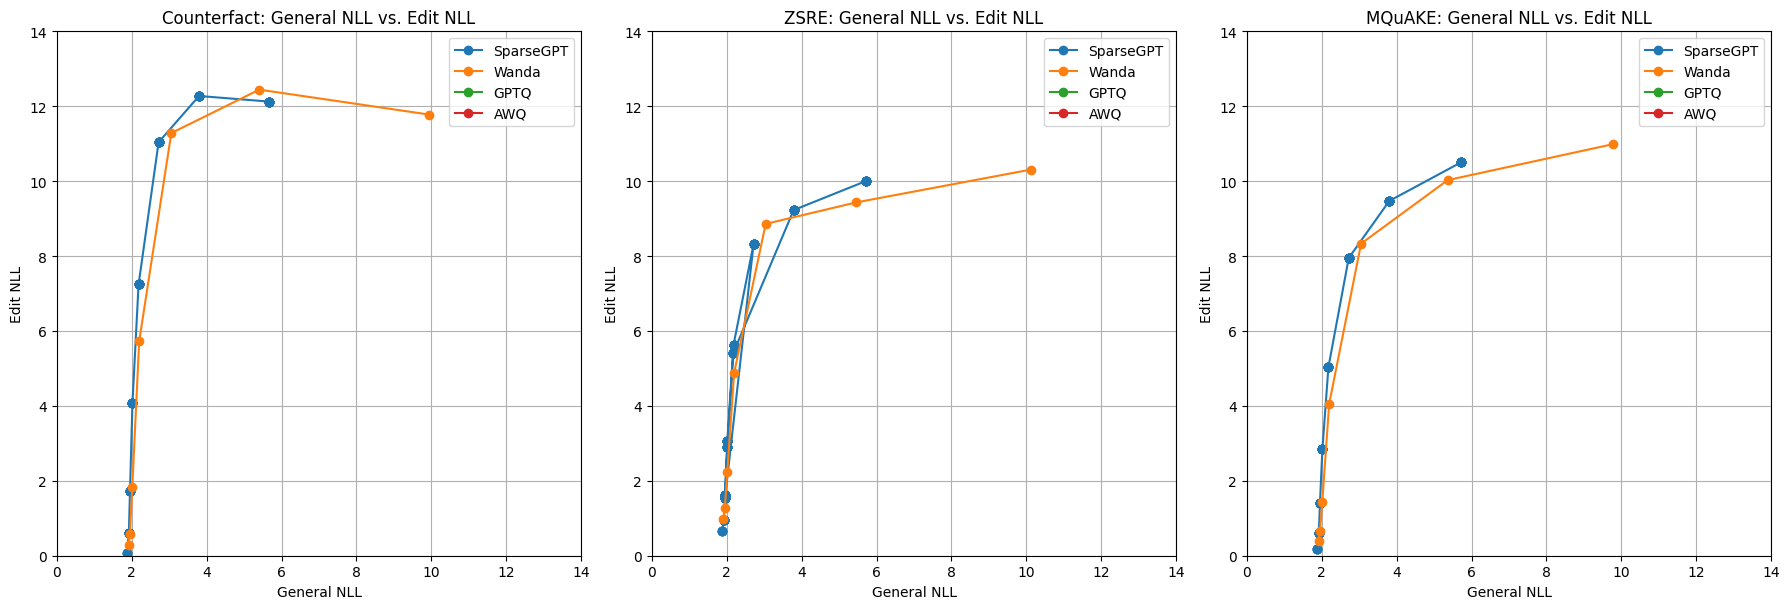

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_ppl_vs_edit_ppl_plots(dfs, titles):
    """
    Creates a row of subplots for PPL vs. edit PPL for each given DataFrame.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames containing the experiment data.
    titles (list of str): List of titles for each DataFrame.
    """
    num_dfs = len(dfs)
    fig, axs = plt.subplots(1, num_dfs, figsize=(6 * num_dfs, 6))

    for i, df in enumerate(dfs):
        ax = axs[i] if num_dfs > 1 else axs

        for method in df['method_name'].unique():
            method_data = df[(df['method_name'] == method) & (df['PPL edits_mean'] < np.inf)]
            ax.errorbar(np.log(method_data['PPL_mean']), np.log(method_data['PPL edits_mean']), 
                        # Uncomment the following line if standard error is available
                        # xerr=np.log(method_data['PPL_standard_error']), yerr=np.log(method_data['PPL_standard_error']),
                        fmt='o-', label=method, capsize=5)

        ax.set_xlabel('General NLL')
        ax.set_ylabel('Edit NLL')
        ax.set_title(f'{titles[i]}: General NLL vs. Edit NLL')
        ax.legend()
        ax.grid(True)

        ax.axis('square')
        ax.set_ylim(0, 14)
        ax.set_xlim(0, 14)

    plt.tight_layout()
    plt.show()

# Example usage
dfs = [edited_counterfact, edited_zsre, edited_mq]  # Replace with your list of dataframes
titles = ["Counterfact", "ZSRE", "MQuAKE"]  # Replace with your titles
create_ppl_vs_edit_ppl_plots(dfs, titles)
